In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

import matplotlib.style as style
style.use('tableau-colorblind10')

plt.style.use("ultrasurfaces_paper_plotstyle.mplstyle")

In [2]:
from toy_mc.histogram import Histogram, plot_histogram

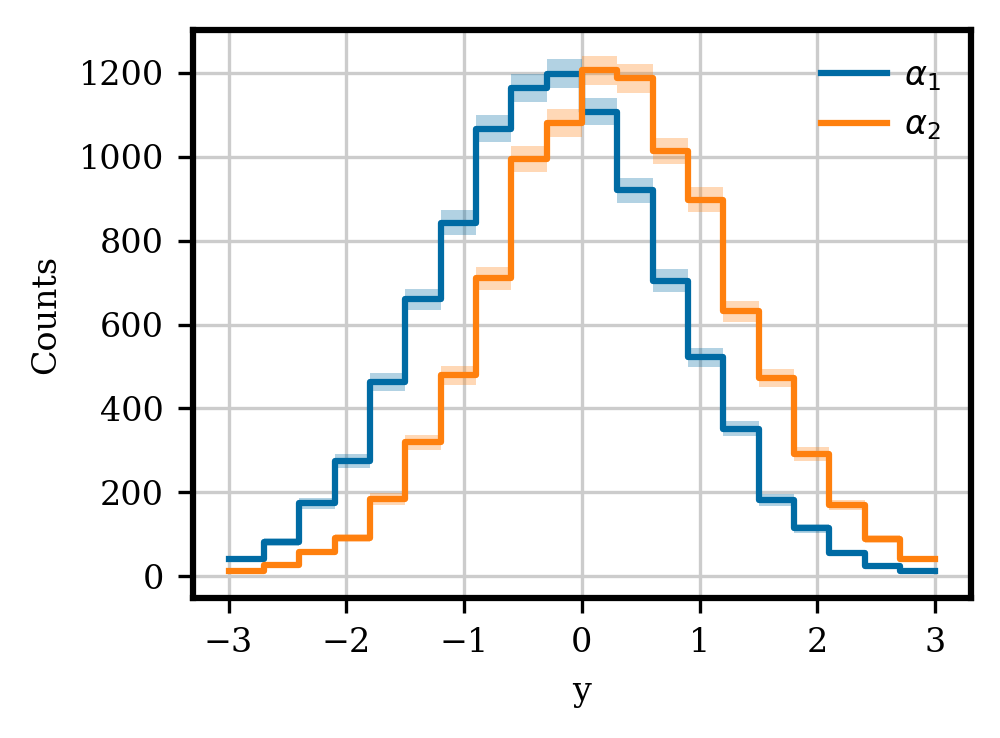

In [3]:
# generate samples from two shifted gaussians
np.random.seed(42)
x = np.concatenate([np.random.normal(-0.25, 1, 10000), np.random.normal(0.25, 1, 10000)])
# class labels for the samples
y = np.concatenate([np.zeros(10000), np.ones(10000)])
# Make Histogram for each class and fill with samples
hist0 = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0.fill(x[y == 0])
hist1 = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist1.fill(x[y == 1])
# plot both distributions
fig, ax = plt.subplots()

plot_histogram(
    hist0,
    # label="Class 0",
    # label=r"$P(y|\alpha_1)$",
    label=r"$\alpha_1$",
    ax=ax,
    )
plot_histogram(
    hist1,
    # label="Class 1",
    # label=r"$P(y|\alpha_2)$",
    label=r"$\alpha_2$",
    ax=ax,
    )

plt.legend()
plt.xlabel("y")
plt.ylabel("Counts")
plt.tight_layout()
# plt.savefig("plot_output/knn_class_distributions.pdf")
plt.savefig("plot_output/knn_class_distributions_new.pdf")
plt.show()


In [4]:
# import KNN classifier and train on the data
from surfaces.sample_weighted_kneighbors import SampleWeightedKNeighborsClassifier

In [5]:
knn = SampleWeightedKNeighborsClassifier(n_neighbors=3000)
# Train the classifier
knn.fit(x[:, np.newaxis], y)
# predict the class probabilities for the samples (without bias correction)
y_pred = knn.predict_proba(x[:, np.newaxis], correct_bias=False)
# Get samples from class 0
x0 = x[y == 0]
# Calculate reweighting factors as the ratio of the class probabilities
w0 =  y_pred[y == 0, 1] / y_pred[y == 0, 0]


In [6]:
# get same prediction but with bias correction
y_pred = knn.predict_proba(x[:, np.newaxis], correct_bias=True)
# Calculate reweighting factors as the ratio of the class probabilities
w0_no_bias =  y_pred[y == 0, 1] / y_pred[y == 0, 0]

1.8481172307863882


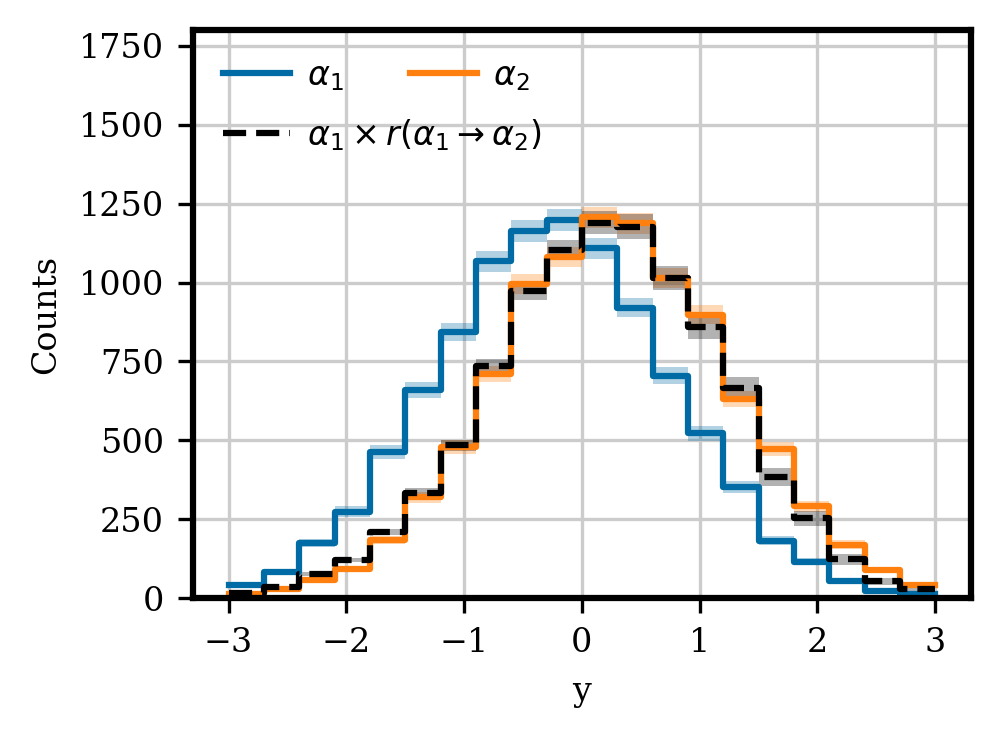

In [7]:
# x = np.concatenate([np.random.normal(-0.25, 1, 10000), np.random.normal(0.25, 1, 10000)])
# # class labels for the samples
# y = np.concatenate([np.zeros(10000), np.ones(10000)])
# # Make Histogram for each class and fill with samples

hist0 = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0.fill(x[y == 0])
hist1 = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist1.fill(x[y == 1])
# weight from class 0 to class 1 using analytically correct weights
reweighted_hist_analytical = Histogram(bin_edges=np.linspace(-3, 3, 21))
true_weights = np.exp(-0.5 * (x[y == 0] - 0.25) ** 2) / np.exp(-0.5 * (x[y == 0] + 0.25) ** 2)
reweighted_hist_analytical.fill(x[y == 0], weights=true_weights)

# Make new Histogram for class 0 and fill with samples and weights
hist0_reweighted = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0_reweighted.fill(x0, weights=w0)

# plot both distributions
fig, ax = plt.subplots()
plot_histogram(
    hist0,
    # label="Class 0",
    label=r"$\alpha_1$",
    ax=ax
    )
plot_histogram(
    hist1,
    # label="Class 1",
    label=r"$\alpha_2$",
    ax=ax
    )
first_legend = plt.legend(ncol=2, bbox_to_anchor=(0.0, 1), loc="upper left")
plt.gca().add_artist(first_legend)

# # plot analytically correct reweighting
# (p,) = plot_histogram(
#     reweighted_hist_analytical,
#     # label=r"Class 0 $\times$ $P(X|Y=1)/P(X|Y=0)$",
#     label=r"$\alpha_1 \times P({\alpha}_2|y)/P({\alpha}_1|y)$",
#     ax=ax,
#     color="k",
#     ls='--'
# )

# plot re-weighting from KNN
(p,) = plot_histogram(
    hist0_reweighted,
    # label=r"Class 0 $\times$ $P(X|Y=1)/P(X|Y=0)$",
    # label=r"$\alpha_1 \times P({\alpha}_2|y)/P({\alpha}_1|y)$",
    label=r"$\alpha_1 \times r(\alpha_1 \rightarrow \alpha_2)$",
    ax=ax,
    color="k",
    ls='--'
)

# calculate pull between the reweighted and the newly drawn distribution
# from class 1
pull = (hist0_reweighted.hist - hist1.hist) / np.sqrt(hist1.hist_unc**2 + hist0_reweighted.hist_unc**2)
# pull = (hist0_reweighted.hist - hist0.hist) / np.sqrt(hist0.hist_unc**2 + hist0_reweighted.hist_unc**2)
print(sum(pull**2)/len(pull))

plt.legend(handles=[p], bbox_to_anchor=(0.0, 0.9), loc="upper left")
plt.xlabel("y")
plt.ylabel("Counts")
plt.ylim(0, 1800)
plt.tight_layout()
# plt.savefig("plot_output/knn_reweighting_analytical.pdf")
plt.savefig("plot_output/knn_reweighting.pdf")
plt.show()


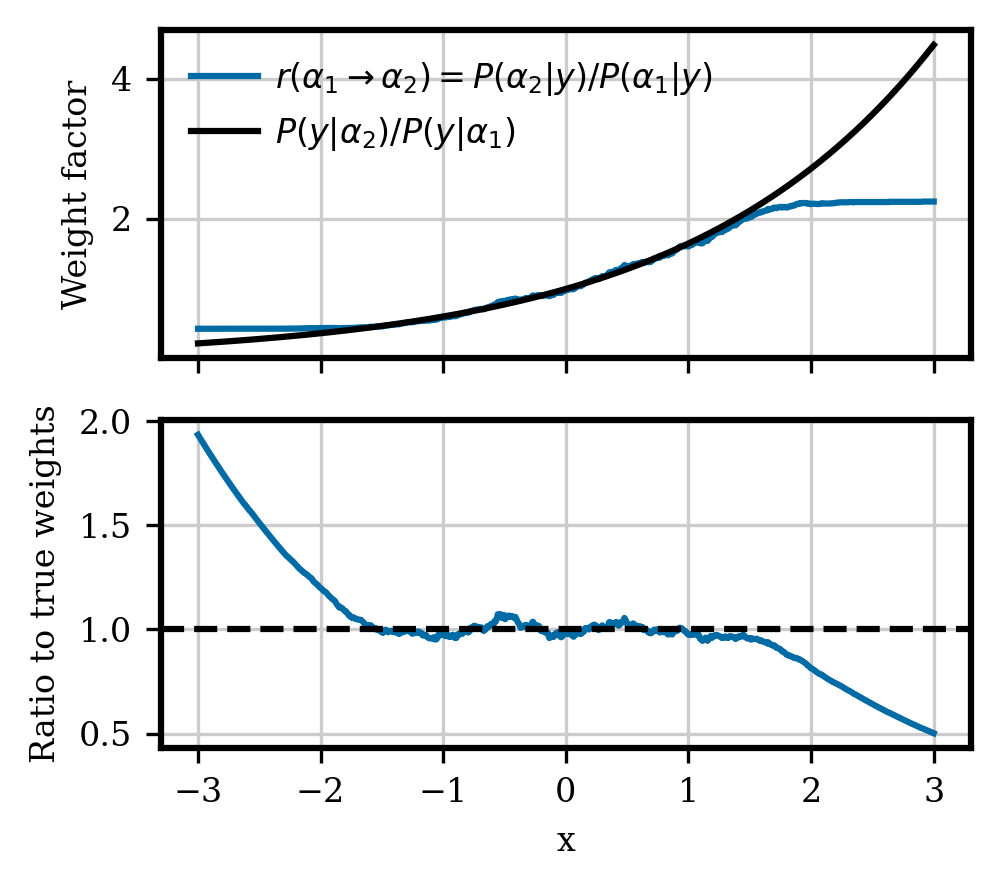

In [8]:
# Get the weight factors from the KNN as a function of x and compare to the 
# the analytical ratio between the two gaussians
x_grid = np.linspace(-3, 3, 1000)
predicted_probs = knn.predict_proba(x_grid[:, np.newaxis], correct_bias=True)
predicted_weights = predicted_probs[:, 1] / predicted_probs[:, 0]
# for comparison, also calculate the predicted weights without bias correction
predicted_probs = knn.predict_proba(x_grid[:, np.newaxis], correct_bias=False)
predicted_weights_no_bias = predicted_probs[:, 1] / predicted_probs[:, 0]
# Calculate the ratio of the two gaussians
true_weights = np.exp(-0.5 * (x_grid - 0.25)**2) / np.exp(-0.5 * (x_grid + 0.25)**2)
# Plot the weights in two panels: Top panel shows the weights as a function of x
# and the ratio of the two gaussians. Bottom panel shows the ratio of the KNN 
# weights and the true weights.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.375, 3))

ax[0].plot(
    x_grid,
    predicted_weights_no_bias,
    label=r'$r(\alpha_1 \rightarrow \alpha_2)=P({\alpha}_2|y)/P({\alpha}_1|y)$'
    )

ax[0].plot(
    x_grid,
    true_weights,
    color="k",
    # label=r"$P(X|Y=1)/P(X|Y=0)$"
    label=r"$P(y|{\alpha}_2)/P(y|{\alpha}_1)$"
    )

ax[0].legend()
ax[0].set_ylabel("Weight factor")

ax[1].plot(x_grid, predicted_weights_no_bias / true_weights, label="KNN weights no bias corr.")

ax[1].axhline(1, color="k", linestyle="--")
# ax[1].legend()
ax[1].set_ylabel("Ratio to true weights")
ax[1].set_xlabel("x")
plt.tight_layout()
# plt.savefig("plot_output/knn_weights_without_bias_correction.pdf")
plt.savefig("plot_output/knn_weights_without_bias_correction_new.pdf")


### Plot how good the prediction is (without skew correction)

Chi2:  42.96076941662177


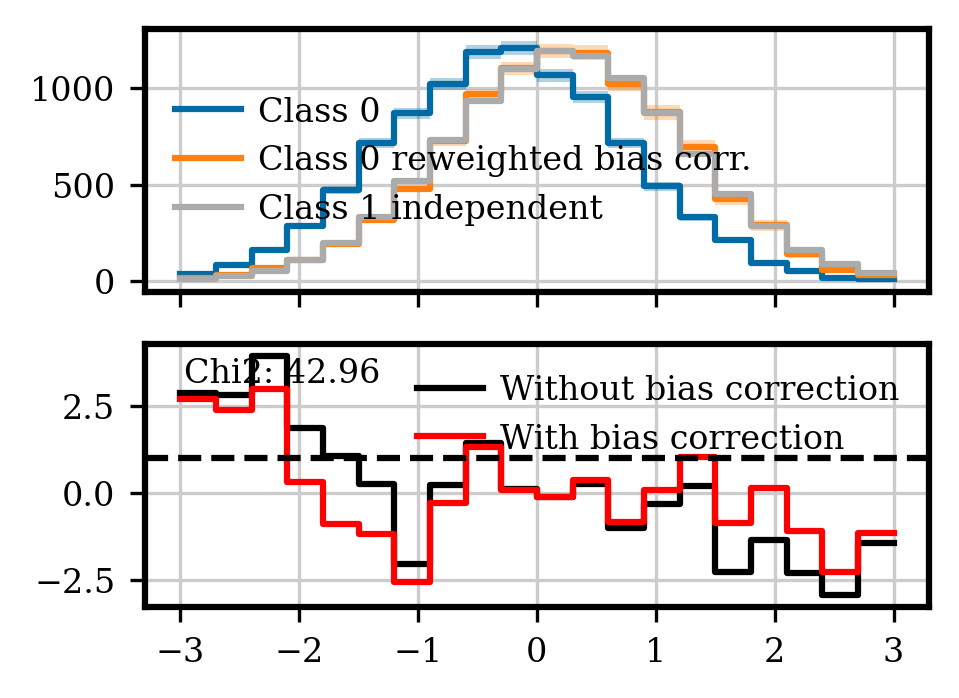

In [ ]:
# Make new Histogram for class 0 and fill with samples and weights
hist0_reweighted = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0_reweighted.fill(x0, weights=w0)
# Second histogram, using weights without bias correction
hist0_reweighted_no_bias = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0_reweighted_no_bias.fill(x0, weights=w0_no_bias)
# Generate another sample from the same distribution as that of class 1
np.random.seed(100)
x1 = np.random.normal(0.25, 1, 1000000)
# Make Histogram for class 1 and fill with samples
hist1_independent = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist1_independent.fill(x1)
hist1_independent = hist1_independent / 100
# Make plot with two panels. Upper panel shows the original distributions and the
# reweighted distribution for class 0. Lower panel shows the ratio of the
# distributions.
fig, ax = plt.subplots(2, 1, sharex=True)
plot_histogram(hist0, label="Class 0", ax=ax[0])
# plot_histogram(hist0_reweighted, label="Class 0 reweighted", ax=ax[0])
plot_histogram(hist0_reweighted_no_bias, label="Class 0 reweighted bias corr.", ax=ax[0])
# plot_histogram(hist1, label="Class 1", ax=ax[0])
plot_histogram(hist1_independent, label="Class 1 independent", ax=ax[0])
ax[0].legend()
# ax[0].set_title("Original and reweighted distributions")
# Divide the Histograms
# ratio = hist0_reweighted / hist1
# ratio = hist0_reweighted / hist1_independent
# # ratio with bias correction
# ratio_no_bias = hist0_reweighted_no_bias / hist1  #_independent
# # Plot the ratio
# plot_histogram(ratio, ax=ax[1], color="k", label="Without bias correction")
# plot_histogram(ratio_no_bias, ax=ax[1], color="r", label="With bias correction")

# calculate pull between the reweighted and the newly drawn distribution
# from class 1
pull = (hist0_reweighted.hist - hist1_independent.hist) / np.sqrt(hist1_independent.hist_unc**2 + hist0_reweighted.hist_unc**2)
pull_no_bias = (hist0_reweighted_no_bias.hist - hist1_independent.hist) / np.sqrt(hist1_independent.hist_unc**2 + hist0_reweighted_no_bias.hist_unc**2)
# plot the chi2 as a step-plot
ax[1].step(hist0.bin_edges, np.append(pull, pull[-1]), where="post", color="k", label="Without bias correction")
ax[1].step(hist0.bin_edges, np.append(pull_no_bias, pull_no_bias[-1]), where="post", color="r", label="With bias correction")
ax[1].legend()
# ax[1].set_title("Ratio of reweighted and original distribution")
# ax[1].set_ylim(0, 2)
ax[1].axhline(1, color="k", linestyle="--")
# print and add to lower panel
print("Chi2: ", np.sum(pull_no_bias ** 2))
ax[1].text(0.05, 0.95, "Chi2: {:.2f}".format(np.sum(pull_no_bias ** 2)), transform=ax[1].transAxes, va="top")
plt.show()

### Plot again (with skew correction)

Chi2:  42.96076941662177


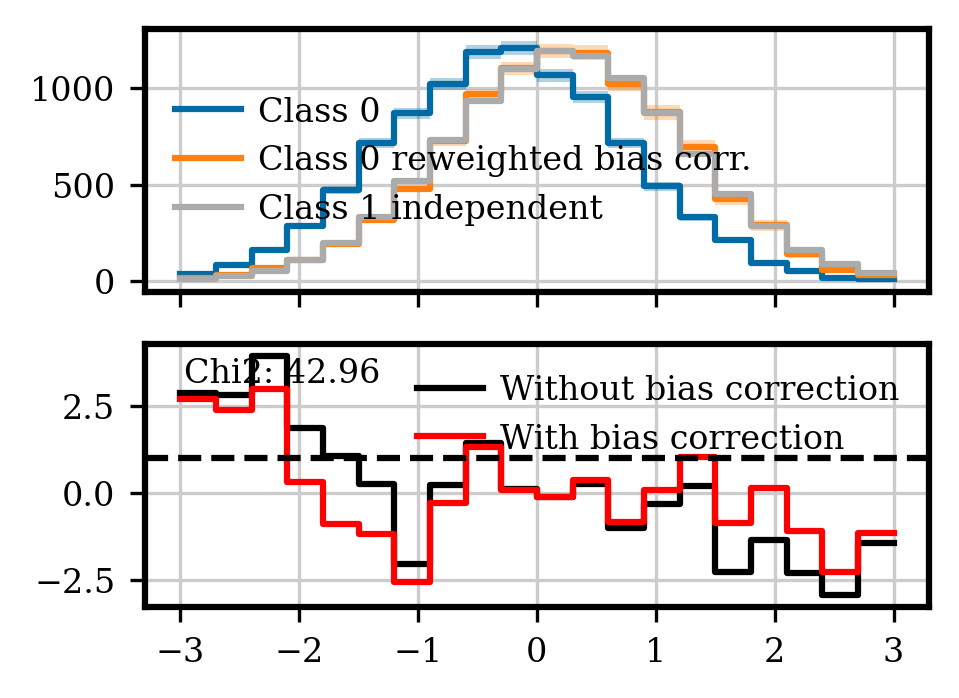

In [14]:
# Make new Histogram for class 0 and fill with samples and weights
hist0_reweighted = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0_reweighted.fill(x0, weights=w0)
# Second histogram, using weights without bias correction
hist0_reweighted_no_bias = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist0_reweighted_no_bias.fill(x0, weights=w0_no_bias)
# Generate another sample from the same distribution as that of class 1
np.random.seed(100)
x1 = np.random.normal(0.25, 1, 1000000)
# Make Histogram for class 1 and fill with samples
hist1_independent = Histogram(bin_edges=np.linspace(-3, 3, 21))
hist1_independent.fill(x1)
hist1_independent = hist1_independent / 100
# Make plot with two panels. Upper panel shows the original distributions and the
# reweighted distribution for class 0. Lower panel shows the ratio of the
# distributions.
fig, ax = plt.subplots(2, 1, sharex=True)
plot_histogram(hist0, label="Class 0", ax=ax[0])
# plot_histogram(hist0_reweighted, label="Class 0 reweighted", ax=ax[0])
plot_histogram(hist0_reweighted_no_bias, label="Class 0 reweighted bias corr.", ax=ax[0])
# plot_histogram(hist1, label="Class 1", ax=ax[0])
plot_histogram(hist1_independent, label="Class 1 independent", ax=ax[0])
ax[0].legend()
# ax[0].set_title("Original and reweighted distributions")
# Divide the Histograms
# ratio = hist0_reweighted / hist1
# ratio = hist0_reweighted / hist1_independent
# # ratio with bias correction
# ratio_no_bias = hist0_reweighted_no_bias / hist1  #_independent
# # Plot the ratio
# plot_histogram(ratio, ax=ax[1], color="k", label="Without bias correction")
# plot_histogram(ratio_no_bias, ax=ax[1], color="r", label="With bias correction")

# calculate pull between the reweighted and the newly drawn distribution
# from class 1
pull = (hist0_reweighted.hist - hist1_independent.hist) / np.sqrt(hist1_independent.hist_unc**2 + hist0_reweighted.hist_unc**2)
pull_no_bias = (hist0_reweighted_no_bias.hist - hist1_independent.hist) / np.sqrt(hist1_independent.hist_unc**2 + hist0_reweighted_no_bias.hist_unc**2)
# plot the chi2 as a step-plot
ax[1].step(hist0.bin_edges, np.append(pull, pull[-1]), where="post", color="k", label="Without bias correction")
ax[1].step(hist0.bin_edges, np.append(pull_no_bias, pull_no_bias[-1]), where="post", color="r", label="With bias correction")
ax[1].legend()
# ax[1].set_title("Ratio of reweighted and original distribution")
# ax[1].set_ylim(0, 2)
ax[1].axhline(1, color="k", linestyle="--")
# print and add to lower panel
print("Chi2: ", np.sum(pull_no_bias ** 2))
ax[1].text(0.05, 0.95, "Chi2: {:.2f}".format(np.sum(pull_no_bias ** 2)), transform=ax[1].transAxes, va="top")
plt.show()

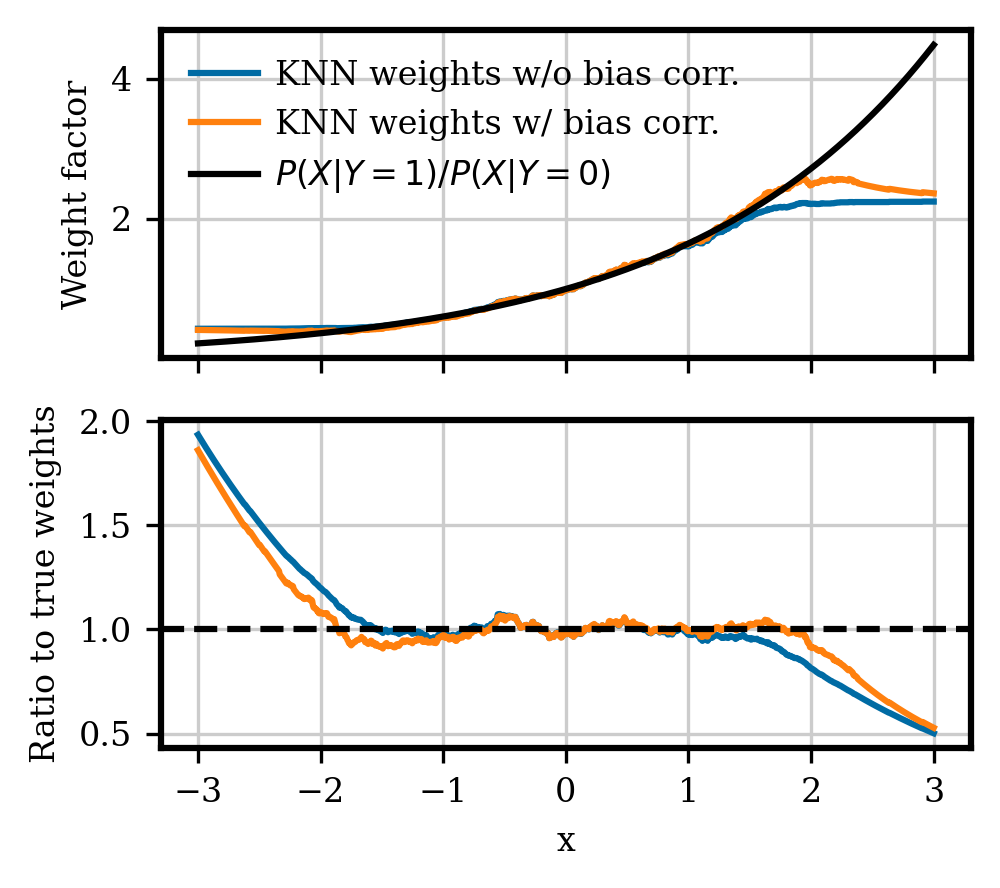

In [17]:
# Get the weight factors from the KNN as a function of x and compare to the 
# the analytical ratio between the two gaussians
x_grid = np.linspace(-3, 3, 1000)
predicted_probs = knn.predict_proba(x_grid[:, np.newaxis], correct_bias=True)
predicted_weights = predicted_probs[:, 1] / predicted_probs[:, 0]
# for comparison, also calculate the predicted weights without bias correction
predicted_probs = knn.predict_proba(x_grid[:, np.newaxis], correct_bias=False)
predicted_weights_no_bias = predicted_probs[:, 1] / predicted_probs[:, 0]
# Calculate the ratio of the two gaussians
true_weights = np.exp(-0.5 * (x_grid - 0.25)**2) / np.exp(-0.5 * (x_grid + 0.25)**2)
# Plot the weights in two panels: Top panel shows the weights as a function of x
# and the ratio of the two gaussians. Bottom panel shows the ratio of the KNN 
# weights and the true weights.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(3.375, 3))
ax[0].plot(x_grid, predicted_weights_no_bias, label="KNN weights w/o bias corr.")
ax[0].plot(x_grid, predicted_weights, label="KNN weights w/ bias corr.")
ax[0].plot(x_grid, true_weights, color="k", label=r"$P(X|Y=1)/P(X|Y=0)$")
ax[0].legend()
ax[0].set_ylabel("Weight factor")
ax[1].plot(x_grid, predicted_weights_no_bias / true_weights, label="KNN weights no bias corr.")
ax[1].plot(x_grid, predicted_weights / true_weights, label="KNN weights")
ax[1].axhline(1, color="k", linestyle="--")
# ax[1].legend()
ax[1].set_ylabel("Ratio to true weights")
ax[1].set_xlabel("x")
plt.tight_layout()
# plt.savefig("plot_output/knn_weights_with_bias_correction.pdf")
